In [1]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import umap.plot as uplot
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import sys 

sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import umap
import hdbscan

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
pd.options.mode.use_inf_as_na = True

In [2]:
def return_confusion_matrix(df1,df2,label1_name,label2_name):
    df = pd.DataFrame(columns=['label1','label2'])
    df['exp_name1'] = df1.exp_name
    df['exp_name2'] = df2.exp_name
    df['label1'] = np.array(df1[label1_name])
    df['label2'] = np.array(df2[label2_name])

    mat = np.zeros((len(set(df1[label1_name])),len(set(df2[label2_name]))))

    for i in np.unique(df.label1):
        data_ = np.unique(df[df.label1==i]['label2'],return_counts=True)
        mat[i,data_[0]] =(data_[1]/sum(data_[1]))*100 

    sns.heatmap(mat,cmap='BrBG_r',annot=True) 

    plt.show()


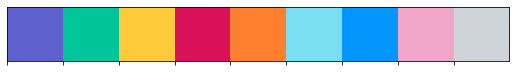

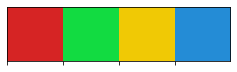

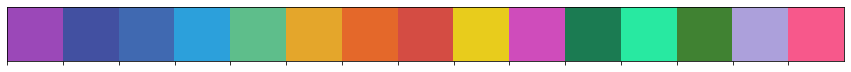

In [3]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.812,	0.3 , 0.734],
                    [0.109, 0.483, 0.324],
                    [0.159,	0.914, 0.635],
                    [0.251,	0.512, 0.198],
                    [0.676,	0.631, 0.859],
                    [0.969,	0.349, 0.549],]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [79]:
def HBDSCAN_plot(data,cmap,n_neighbors,min_dist,random_state):


    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data)
    clusterable_embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=random_state,
    ).fit_transform(data_umap)

    labels = hdbscan.HDBSCAN(
        # min_samples=10,
        min_cluster_size=10,
    ).fit_predict(clusterable_embedding)

    clustered = (labels >= 0)
    df_2d_exc = {'UMAP1':clusterable_embedding[:, 0],
             'UMAP2':clusterable_embedding[:, 1],
             'class':labels}
    fig,ax12d = plt.subplots(figsize=[8,8])
    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=cmap[:len(set(labels))],ax=ax12d)
            
    return labels,clusterable_embedding



In [72]:
discarded_exps = ['xuan_151118_E1',
'xuan_15319_E1' ,
'xuan_20919_E2',
'xuan_27919_E1',
'xuan_27919_E2',
'xuan_27919_E3',
'NC_20717_E5' ,
'NC_25717_E2',
'payam_31019_E5',
'payam_101019_E5',
'NC_24717_E1']

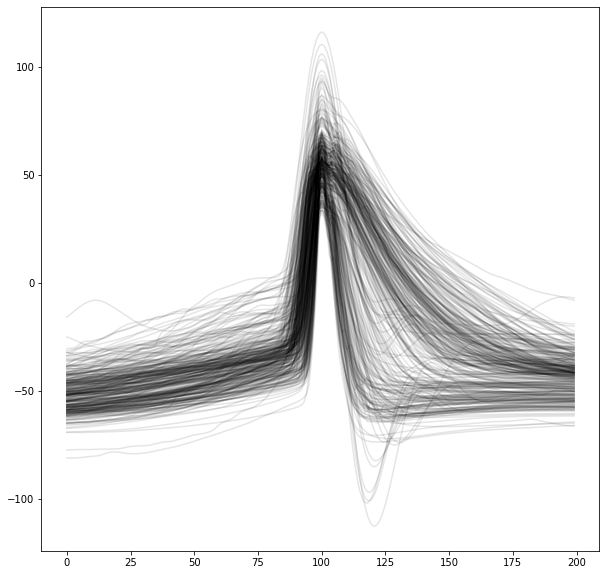

In [74]:
# %matplotlib widget

ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated.pkl")
ephys = ephys[~ephys.exp_name.isin(discarded_exps)]


data_ephys_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][ephys.columns[1:]]
data_ephys_FN_acsf = data_ephys_FN_acsf[data_ephys_FN_acsf.trialnr==0]


data_wave_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][['waveform','tau', 'exp_name', 'cond', 'trialnr']]
data_wave_FN_acsf=data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]
data_wave_FN_acsf.drop_duplicates('exp_name')

# exps_with_double_trials = np.array(data_wave_FN_acsf.exp_name)[list(np.where(np.unique(data_wave_FN_acsf.exp_name,return_counts=True)[1]>1)[0])]
# data_wave_FN_acsf = data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]

fig,ax = plt.subplots(figsize=[10,10])
# plt.ion
plt.plot(np.vstack(data_wave_FN_acsf['waveform']).T,c='k',alpha=0.1)
plt.show()


In [75]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,title=None,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    if title!=None:
        plt.title(title)
    plt.show()

    return labels_exc,mapper,reducer

In [80]:
waves = normalize(np.vstack(data_wave_FN_acsf['waveform']))

# find_optimum_res(waves)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


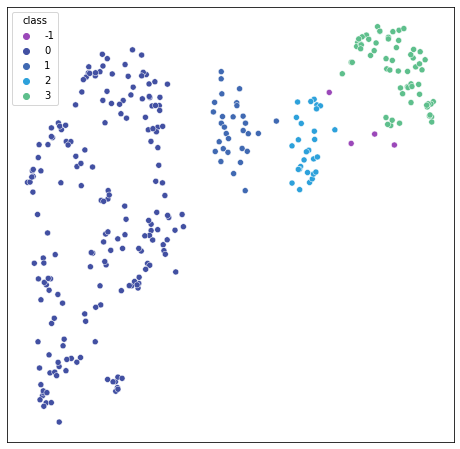

In [82]:
labels_wave,embedding = HBDSCAN_plot(waves,coherence_colors,20,0.1,42)
data_wave_FN_acsf['labels_wave'] = labels_wave

In [102]:
data_wave_FN_acsf.labels_wave[data_wave_FN_acsf.labels_wave==-1] =4

<ipython-input-102-a2c4cc400975>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wave_FN_acsf.labels_wave[data_wave_FN_acsf.labels_wave==-1] =4


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean accuracy 59.315789473684205


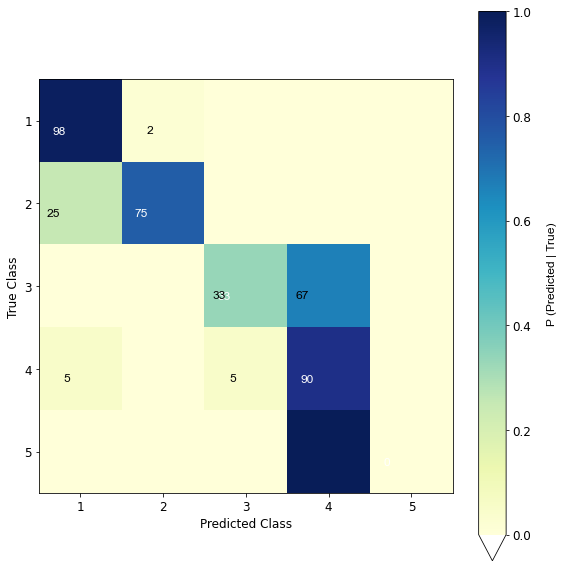

In [103]:
from xg_boost_classifier import * 
_=return_xg_boost_trees_classification(data_wave_FN_acsf['waveform'].to_numpy(),data_wave_FN_acsf.labels_wave)


In [84]:
np.unique(labels_wave,return_counts=True)

(array([-1,  0,  1,  2,  3], dtype=int64),
 array([  4, 188,  30,  28,  62], dtype=int64))

0


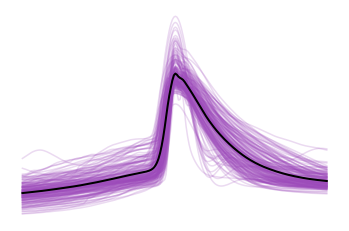

1


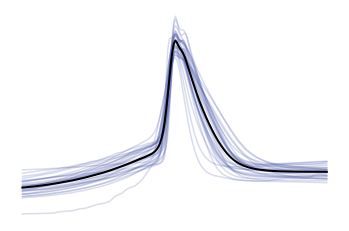

2


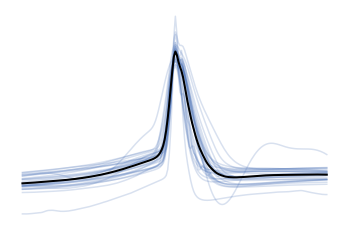

3


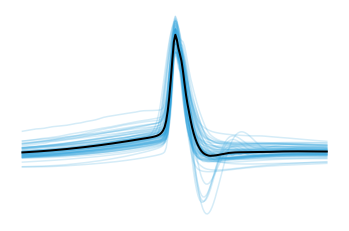

-1


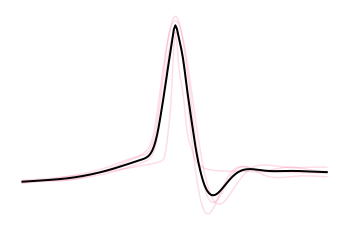

In [85]:
for i in set(labels_wave):
    # if i>0:
        print(i)
        fig,ax = plt.subplots()
        fig.patch.set_visible(False)
        ax.axis('off')
        # data_wave_FN_acsf[data_wave_FN_acsf.labels_wave==i]['half_width']
        plt.plot(np.arange(0,10,1/20),(np.vstack(data_wave_FN_acsf[data_wave_FN_acsf.labels_wave==i]['waveform']).T),c=coherence_colors[i],alpha=0.2)
        plt.plot(np.arange(0,10,1/20),np.mean(np.vstack(data_wave_FN_acsf[data_wave_FN_acsf.labels_wave==i]['waveform']).T,axis=1),c='black',linewidth=2,label=i)
        plt.xticks([])
        plt.yticks([])
        plt.show()
# plt.legend()

In [86]:
data_ephys_FN_acsf['labels_wave'] = labels_wave
data_ephys_FN_acsf.columns

Index(['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
       'tau', 'exp_name', 'cond', 'trialnr', 'labels_wave'],
      dtype='object')

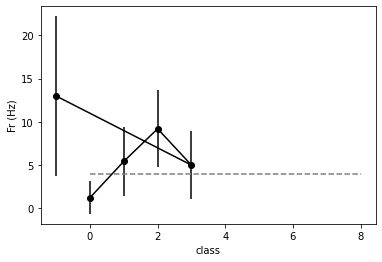

<ipython-input-90-ef519c298065>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ap_width[i],frs[i],marker='o',c=coherence_colors[i],label = list(set(data_ephys_FN_acsf['labels_wave']))[i])


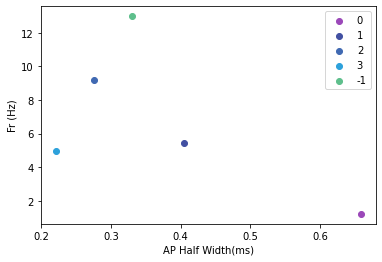

In [90]:
frs = []
ap_width = []  
frs_std = []
ap_width_std = []

for i in set(data_ephys_FN_acsf['labels_wave']):
    frs.append(np.mean(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['fr']))
    frs_std.append(np.std(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['fr']))

    ap_width.append(np.mean(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['mean_width']))
    ap_width_std.append(np.std(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['mean_width']))

plt.errorbar(list(set(data_ephys_FN_acsf['labels_wave'])),frs,yerr=frs_std,marker='o',c='black')
plt.hlines(4,0,8,linestyles='dashed',color='grey')
plt.ylabel('Fr (Hz)')
plt.xlabel('class')
plt.show()

for i in range(len(ap_width)):
    plt.scatter(ap_width[i],frs[i],marker='o',c=coherence_colors[i],label = list(set(data_ephys_FN_acsf['labels_wave']))[i])
    plt.ylabel('Fr (Hz)')
    plt.xlabel('AP Half Width(ms)')
    plt.legend()
plt.show()

In [91]:

data_ephys_FN_acsf['labels_wave'] = labels_wave
ephys_exc = data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave.isin([0])]
ephys_inh = data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave.isin([-1,1,2,3])]
cols = ephys_exc.columns
ephys_exc_for_cluster = normalize(ephys_exc[cols[:-5]].to_numpy())
ephys_inh_for_cluster = normalize(ephys_inh[cols[:-5]].to_numpy())

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-92-c3180ae601b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephys_inh['labels_ephys']  =labels_inh
<ipython-input-92-c3180ae601b2>:5: SettingWithCopyWarning: 
A value is trying to

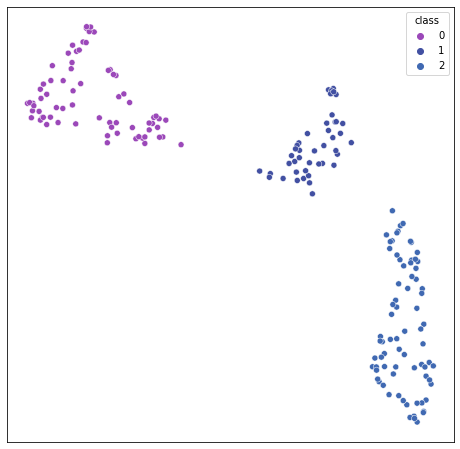

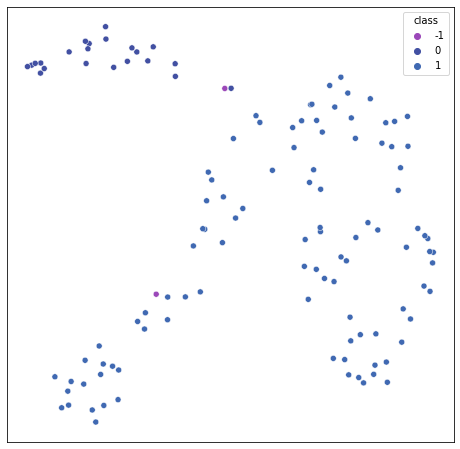

In [92]:

labels_exc, _ = HBDSCAN_plot(ephys_exc_for_cluster,coherence_colors,20,0.1,42)
labels_inh, _ = HBDSCAN_plot(ephys_inh_for_cluster,coherence_colors,20,0.1,42)

ephys_inh['labels_ephys']  =labels_inh
ephys_exc['labels_ephys']  =labels_exc

In [70]:
def pax_plot_data(data,cols,labels,pallete, save= False):
    # # Import data
    import paxplot
    from sklearn.preprocessing import MinMaxScaler

    from sklearn.preprocessing import StandardScaler
    scaler = MinMaxScaler()
    scaler_std = StandardScaler()

    data_to_plot = data
    cols = cols
    labels =  labels
    # Create figure
    paxfig = paxplot.pax_parallel(n_axes=len(cols))
    paxfig.set_figheight(10)
    paxfig.set_figwidth(30)

    scaled = scaler.fit_transform(data_to_plot.to_numpy())

    scaled_std = scaler.fit_transform(data_to_plot.to_numpy())
    for i in list(set(labels)):
        idx = np.where(labels==i)
        paxfig.plot(
            scaled[idx[0],:], #stats.zscore(df_acsf_1.to_numpy())
            line_kwargs={'alpha': 0.5, 'color': pallete[i], 'zorder': 1}
        )

    for  ax in paxfig.axes:   
        ax.tick_params(axis='x', labelsize=20,rotation=90)
        ax.tick_params(axis='y', labelsize=10)
    # # Add labels
    paxfig.set_labels(cols)
    if save: 
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/paralell_plot_all_acsf.png',dpi=200)

    plt.show()

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\paxplot\core.py:842: Warning: The function you have called (set_figheight) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\paxplot\core.py:842: Warning: The function you have called (set_figwidth) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(


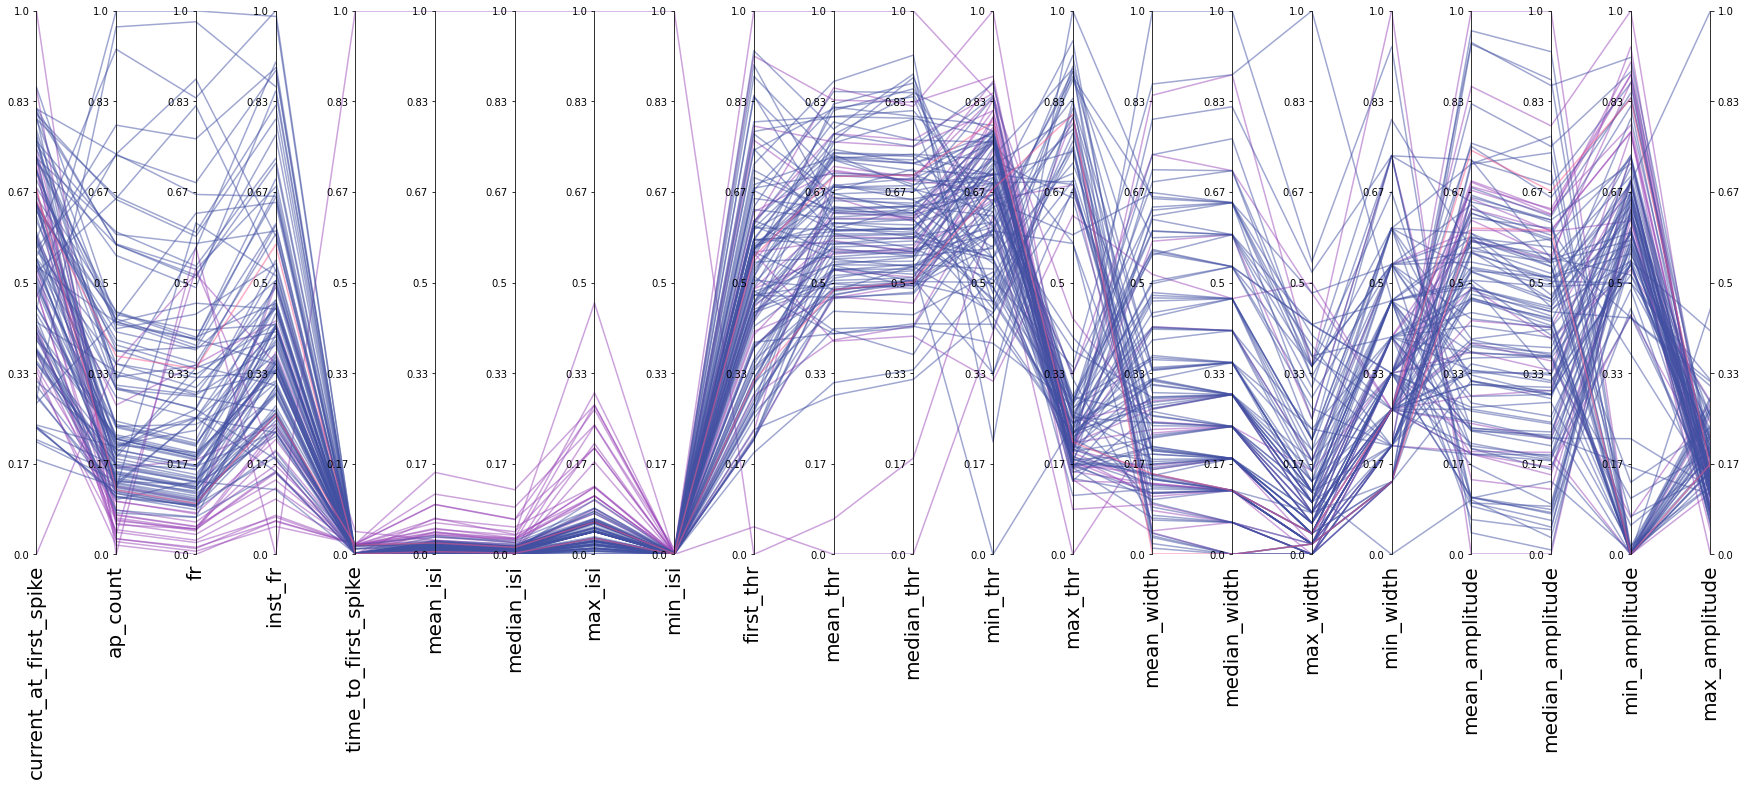

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\paxplot\core.py:842: Warning: The function you have called (set_figheight) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\paxplot\core.py:842: Warning: The function you have called (set_figwidth) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(


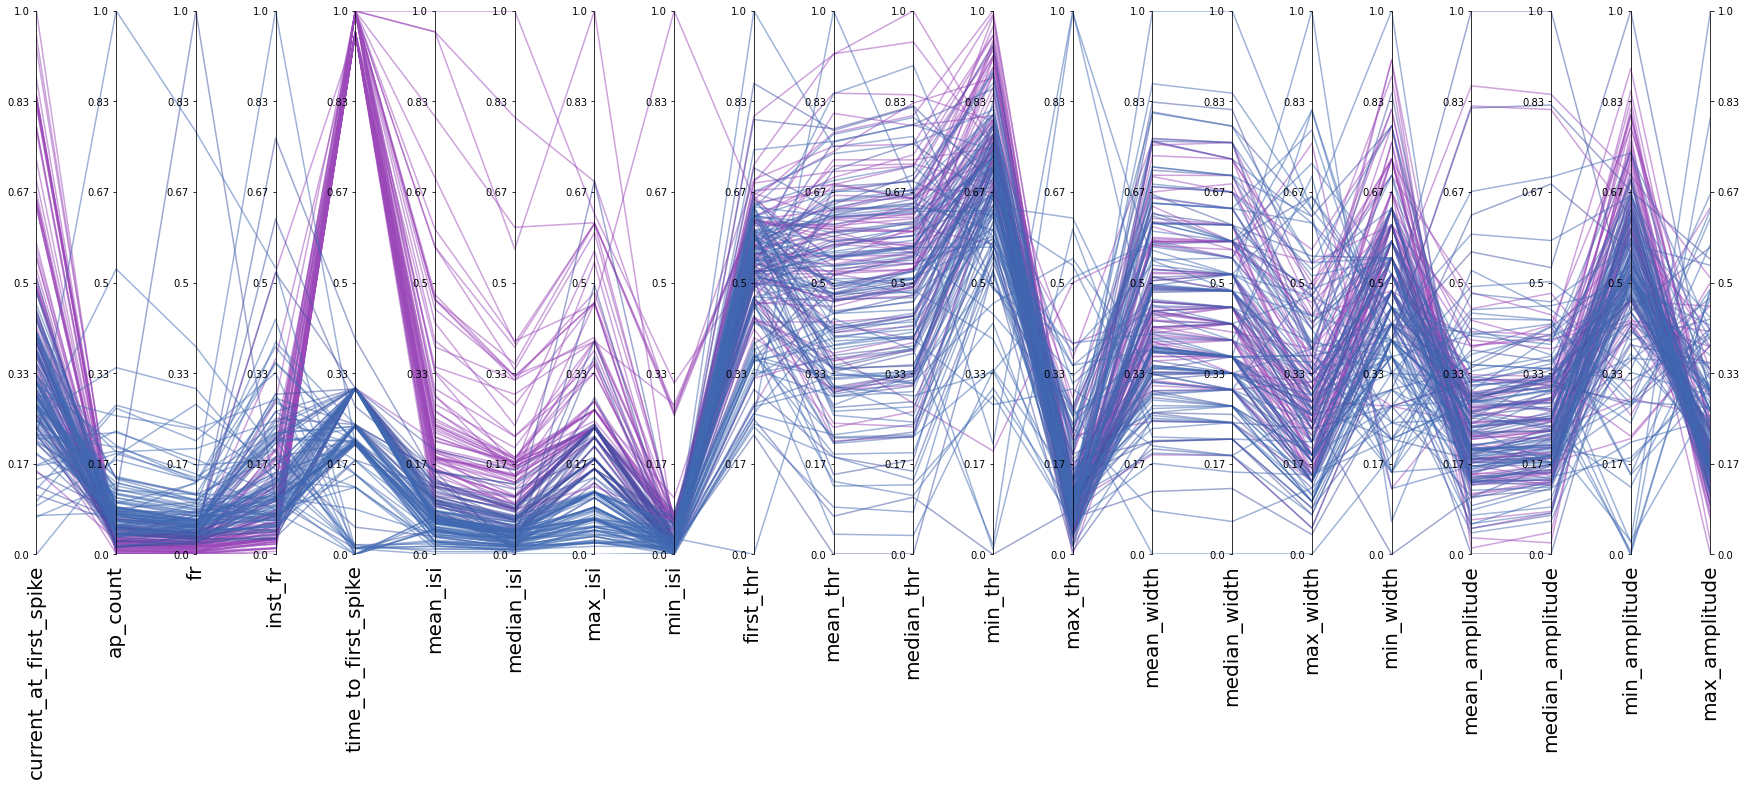

In [96]:
pax_plot_data(ephys_inh[ephys_inh.columns[:-6]],ephys_inh.columns[:-6],ephys_inh.labels_ephys,coherence_colors)
pax_plot_data(ephys_exc[ephys_exc.columns[:-6]],ephys_exc.columns[:-6],ephys_exc.labels_ephys,coherence_colors)

In [54]:
def return_name_date_exp_fn(string):

  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp 
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1]
    date = date.replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp    
  elif 'Payam' in string or 'payam' in string :
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp

In [55]:

df = pd.read_csv('D:/Biophysical_cluster/cluster_params_rect_filt.csv')
df.exp_name = df.exp_name.apply(return_name_date_exp_fn)
df = df[~df.exp_name.isin(discarded_exps)]
df = df[df.columns[1:]]
df_acsf = df[df.cond.isin(['ACSF','aCSF','aCSF_BIC'])]
df_acsf = df_acsf[df_acsf.trial==0]
df_acsf['labels_wave']=labels_wave



In [56]:
df_biophys_exc = df_acsf[df_acsf.labels_wave ==1]
df_biophys_inh = df_acsf[df_acsf.labels_wave == 0 ]

df_biophys_exc = df_biophys_exc[df_biophys_exc.rsqared_V>0.7]
df_biophys_inh = df_biophys_inh[df_biophys_inh.rsqared_V>0.7]



In [ ]:
cols_bio = [ 'C (nF):', 'gl (nS):', 'El (mV):', 'Vr (mV):', 'Vt* (mV):', 'DV (mV):',]
bio_phys_exc = normalize(np.vstack(df_biophys_exc[cols_bio].to_numpy()))

